In [1]:
#Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from skimage.transform import rescale
import skimage.color as color
import cv2
from PIL import Image
#from skimage.external import tifffile
from skimage.transform import resize

import tensorflow as tf
import keras
from keras import backend
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D,GlobalAveragePooling2D,Input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,Model, load_model
from keras.optimizers import SGD, Adam
from keras.applications import ResNet50, VGG16, MobileNet, Xception, DenseNet121
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.backend import clear_session

## Image Augmentation
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import argparse

from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import cv2
import os
from os import listdir
from tqdm import tqdm
import time
import csv
import pickle

from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras import Sequential
from tensorflow.keras.backend import clear_session

In [2]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# Define model parameters
INPUT_SHAPE = (128, 128, 3) # Image Dimensions
BATCH_SIZE = 128
DROPOUT_RATE = 0.5
EPOCHS = 25
LR = 0.0001 # Learning Rate
REG_STRENGTH = 0.01 # Regularization Strength
NFOLDS = 5 # No of folds for cross validation
WORKERS = 4 # Multithreading no of threads
MAXQ = 10 # Max Queue size for multithreading
THRES = [0.2] * 17 # Threshold for truth value of label, applied on sigmoid output.

TRAIN_PATH = '/mnt/fast0/pp837/train_file_haze'
TEST_PATH = '/mnt/fast0/pp837/test_file_haze'

TRAIN_CSV_PATH = '/mnt/fast0/pp837/train_label.csv'
TEST_CSV_PATH = '/mnt/fast0/pp837/test_label.csv'

In [4]:
# Construct dataframes holding training and test data information
df_train = pd.read_csv(TRAIN_CSV_PATH)
df_test = pd.read_csv(TEST_CSV_PATH)

df_train['image_name'] = df_train['image_name'].astype(str)
df_test['image_name'] = df_test['image_name'].astype(str)

df_test['tags'] = df_test['tags'].apply(lambda x: x.split(' '))

print(df_train.head())
print(df_test.head())

        image_name                 tags
0   train_3577.jpg         haze primary
1  train_10327.jpg        clear primary
2   train_1243.jpg  clear primary water
3  train_17066.jpg        clear primary
4  train_15959.jpg        clear primary
       image_name                                        tags
0  test_32752.jpg                            [clear, primary]
1   test_7767.jpg                            [clear, primary]
2   test_4254.jpg  [agriculture, clear, cultivation, primary]
3  test_23119.jpg                            [clear, primary]
4  test_22101.jpg               [agriculture, clear, primary]


In [5]:
df_test.shape

(8096, 2)

In [6]:
df_train.shape

(32383, 2)

In [7]:
# These files are numpy Arrays with shape Nx1
X_train_files = np.array(df_train['image_name'].tolist())
X_train_files.reshape((X_train_files.shape[0], 1))
y_train = np.array(df_train['tags'].tolist())

In [8]:
# There are 17 Labels and each image is tagged with multiple labels
# Lets print out the unique label list

labels = []

for tag in df_train['tags'].values:
    labels_in_tag = tag.split(' ')
    for label in labels_in_tag:
        if label not in labels:
            labels.append(label)
        
labels.sort()
print(labels)

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


blow_down is tagged least no of times: 74
primary is tagged max no of times: 29978


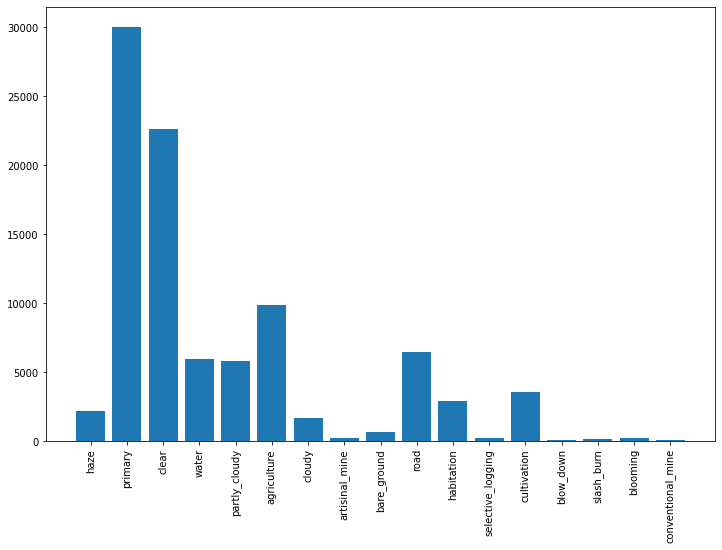

In [9]:
#Distribution of the labels :
plt.figure(figsize=(12, 8))

labels_count = {}

for tag in df_train['tags'].values:
    labels_in_tag = tag.split(' ')
    for label in labels_in_tag:
        if label in labels_count:
            labels_count[label] += 1
        else:
            labels_count[label] = 0
            
min_label = min(labels_count, key=labels_count.get)
max_label = max(labels_count, key=labels_count.get)

print(min_label+" is tagged least no of times: "+str(labels_count[min_label]))
print(max_label+" is tagged max no of times: "+str(labels_count[max_label]))
            
plt.bar(range(len(labels_count)), list(labels_count.values()), align='center')
plt.xticks(range(len(labels_count)), list(labels_count.keys()), rotation=90)

plt.show()

In [10]:
# Define MobileNet model for Haze removal
def create_model():
    img = Input(shape = (128, 128, 3))
    model_mob = MobileNet(include_top=False, weights='imagenet', input_tensor=img, input_shape=None, pooling='avg')

    final_layer = model_mob.layers[-1].output
    dense_layer_1 = Dense(128, activation = 'relu')(final_layer)
    output_layer = Dense(17, activation = 'sigmoid')(dense_layer_1)

    model = Model(model_mob.input, output_layer)

    return model

clear_session()

model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 64, 64, 32)        0     

In [11]:
#Define model evaluation metric : F2 Beta score:

def f2_score(y_true, y_pred):
    y_true = tf.cast(y_true, "int32")
    y_pred = tf.cast(tf.round(y_pred), "int32") # implicit 0.5 threshold via tf.round
    y_correct = y_true * y_pred
    sum_true = tf.reduce_sum(y_true, axis=1)
    sum_pred = tf.reduce_sum(y_pred, axis=1)
    sum_correct = tf.reduce_sum(y_correct, axis=1)
    precision = sum_correct / sum_pred
    recall = sum_correct / sum_true
    f_score = 5 * precision * recall / (4 * precision + recall)
    f_score = tf.where(tf.math.is_nan(f_score), tf.zeros_like(f_score), f_score)
    return tf.reduce_mean(f_score)

In [12]:
#Run the model  with k-fold cross validation:

num_fold = 0
EPOCHS = 25

y_test = []

folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=1).split(X_train_files, y_train)

for train_index, val_index in folds:
    X_train_files_fold = X_train_files[train_index]
    y_train_fold = y_train[train_index]
    X_val_files_fold = X_train_files[val_index]
    y_val_fold = np.array(y_train[val_index])
    
    train_df = pd.DataFrame(list(zip(X_train_files_fold, y_train_fold)), columns = ['image_name', 'tags'])
    val_df = pd.DataFrame(list(zip(X_val_files_fold, y_val_fold)), columns = ['image_name', 'tags'])
    
    train_df['tags'] = train_df['tags'].apply(lambda x: x.split(' '))
    #print(train_df.head(5))
    #print("*****")
    val_df['tags'] = val_df['tags'].apply(lambda x: x.split(' '))
    #print(val_df.head(5))

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
    )
    
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        directory=TRAIN_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
    )
    
    val_datagen = ImageDataGenerator(
        rescale=1./255
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        val_df,
        directory=TRAIN_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
    )
    
    test_datagen = ImageDataGenerator(
        rescale=1./255
    )
    
    test_generator = test_datagen.flow_from_dataframe(
        df_test,
        directory=TEST_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
        shuffle=False,
    )

    model_path_of_fold = '/mnt/fast0/pp837/' + 'weights_of_fold_' + str(num_fold) + '.h5'
    
    clear_session()
    model = create_model()
    
    adam = Adam(learning_rate=LR)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[f2_score])
    
    callbacks = [
        ModelCheckpoint(model_path_of_fold, monitor='val_f2_score', save_best_only=True, mode='max'),
        ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001)
    ]
    
    model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                       workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

    model.load_weights(model_path_of_fold)

    p_test = model.predict(test_generator, workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)
    y_test.append(p_test)
    num_fold+=1

Found 25906 validated image filenames belonging to 17 classes.
Found 6477 validated image filenames belonging to 17 classes.
Found 8096 validated image filenames belonging to 17 classes.
Epoch 1/25
203/203 [==============================] - 54s 232ms/step - loss: 0.3016 - f2_score: 0.7122 - val_loss: 0.1520 - val_f2_score: 0.8254
Epoch 2/25
203/203 [==============================] - 52s 254ms/step - loss: 0.1215 - f2_score: 0.8575 - val_loss: 0.1195 - val_f2_score: 0.8637
Epoch 3/25
203/203 [==============================] - 53s 259ms/step - loss: 0.1122 - f2_score: 0.8699 - val_loss: 0.1076 - val_f2_score: 0.8764
Epoch 4/25
203/203 [==============================] - 50s 244ms/step - loss: 0.1057 - f2_score: 0.8741 - val_loss: 0.1047 - val_f2_score: 0.8818
Epoch 5/25
203/203 [==============================] - 49s 239ms/step - loss: 0.1018 - f2_score: 0.8790 - val_loss: 0.1033 - val_f2_score: 0.8860
Epoch 6/25
203/203 [==============================] - 56s 275ms/step - loss: 0.0980 - f2

In [13]:
# Average out the results obtained from k folds of cross validation
result_haze = np.array(y_test[0])
for i in range(1, NFOLDS):
    result_haze += np.array(y_test[i])
result_haze /= NFOLDS
result_haze = pd.DataFrame(result_haze, columns = labels)
result_haze.head()

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,0.000799,1.639426e-06,0.000034,0.000430,0.000268,0.999668,0.000023,0.000021,0.000292,0.000157,0.000261,0.000199,0.999978,0.000075,0.000025,0.000015,0.001561
1,0.000487,5.651362e-07,0.000096,0.000090,0.000057,0.999785,0.000109,0.000003,0.000115,0.000265,0.000155,0.000013,0.999399,0.000367,0.000012,0.000017,0.007508
2,0.930208,2.981378e-04,0.005630,0.000541,0.000282,0.979949,0.000010,0.000616,0.234784,0.024792,0.000352,0.036338,0.999947,0.045867,0.000164,0.012029,0.127804
3,0.000537,1.017490e-06,0.000026,0.000661,0.000020,0.999975,0.000002,0.000001,0.000374,0.000258,0.000011,0.000024,0.999999,0.000064,0.000010,0.000010,0.000283
4,0.850744,1.506044e-02,0.103372,0.000167,0.000095,0.968264,0.000822,0.016538,0.094722,0.048283,0.010525,0.024269,0.972536,0.208511,0.000560,0.001523,0.632478


In [14]:
#Pickling the result_new df
import pickle
pickle1_out = open('result_mb_haze.pickle', 'wb')
pickle.dump(result_haze, pickle1_out, protocol=4)
pickle1_out.close()

In [16]:
# Create prediction flag and create a submission file for kaggle submission
# preds = []
# for i in range(result_haze.shape[0]):
#     a = result_haze.ix[[i]]
#     a = a.apply(lambda x: x > THRES, axis=1)
#     a = a.transpose()
#     a = a.loc[a[i] == True]
#     ' '.join(list(a.index))
#     preds.append(' '.join(list(a.index)))
    
# df_test['tags'] = preds
# df_test['image_name'] = df_test['image_name'].astype(str).str.slice(stop=-4)
# df_test.to_csv('submit_haze.csv', index=False)

preds = []
for i in range(result_haze.shape[0]):
    a = result_haze.iloc[[i]]
    a = a.apply(lambda x: x > THRES, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))

In [17]:
df_test['pred_tags'] = preds
df_test.head(5)

,image_name,tags,pred_tags
0,test_32752.jpg,"[clear, primary]",clear primary
1,test_7767.jpg,"[clear, primary]",clear primary
2,test_4254.jpg,"[agriculture, clear, cultivation, primary]",agriculture clear cultivation primary
3,test_23119.jpg,"[clear, primary]",clear primary
4,test_22101.jpg,"[agriculture, clear, primary]",agriculture clear primary road water


In [21]:
from sklearn.metrics import fbeta_score

def calc_acc(df_test):
    test = df_test['tags']
    pred = df_test['pred_tags'].apply(lambda x: x.split(' '))
    
    from sklearn.preprocessing import MultiLabelBinarizer
    
    mlb = MultiLabelBinarizer()
    test = mlb.fit_transform(test)
    pred = mlb.transform(pred)
    score = fbeta_score(test,pred,beta=.5,average='weighted')
    return score

acc_score = calc_acc(df_test)
print("Accuracy Score: ", acc_score)

Accuracy Score:  0.8416237285305584
